In [ ]:
#라이브러리 추가
%tensorflow_version 2.x
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.experimental.preprocessing import Rescaling
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
#구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/데사개/images.tar.gz .

In [ ]:
#압축 해제
!tar -xf images.tar.gz

In [ ]:
#분류별 폴더 생성
!cd images; mkdir food; mkdir interior; mkdir exterior

In [ ]:
#사진을 각각 일치하는 폴더로 이동
!cd images; ls | grep -e food | xargs mv -t food
!cd images; ls | grep -e interior | xargs mv -t interior
!cd images; ls | grep -e exterior | xargs mv -t exterior
file_dir = r'images'

mv: cannot move 'food' to a subdirectory of itself, 'food/food'
mv: cannot move 'interior' to a subdirectory of itself, 'interior/interior'
mv: cannot move 'exterior' to a subdirectory of itself, 'exterior/exterior'


In [ ]:
#사진의 정보를 ImageDataGenerator을 통해 학습에 적합한 데이터로 변경
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.2)
class_names = [
               'food',
               'interior',
               'exterior'
]
train_gen = img_gen.flow_from_directory(file_dir, target_size=(128,128), classes=class_names, batch_size=32, shuffle=True,class_mode='categorical', subset='training')
valid_gen = img_gen.flow_from_directory(file_dir, target_size=(128,128), classes=class_names, batch_size=32, shuffle=False,class_mode='categorical', subset='validation')

Found 36000 images belonging to 3 classes.
Found 9000 images belonging to 3 classes.


In [ ]:
train_images, train_labels = train_gen.next()

In [ ]:
test_images = np.concatenate([valid_gen.next()[0] for i in range(valid_gen.__len__())])
test_labels = np.concatenate([valid_gen.next()[1] for i in range(valid_gen.__len__())])
#test_labels = np.eye(3)[valid_gen.classes]
print(test_images.shape)
print(test_labels.shape)

(9000, 128, 128, 3)
(9000, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


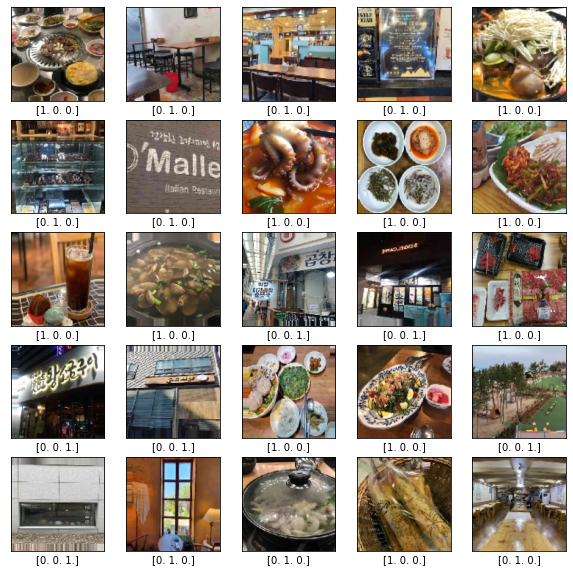

In [ ]:
#학습용 데이터가 잘 저장이 되었는지 확인
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i]/255, cmap=plt.cm.binary)
  plt.xlabel(train_labels[i])
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


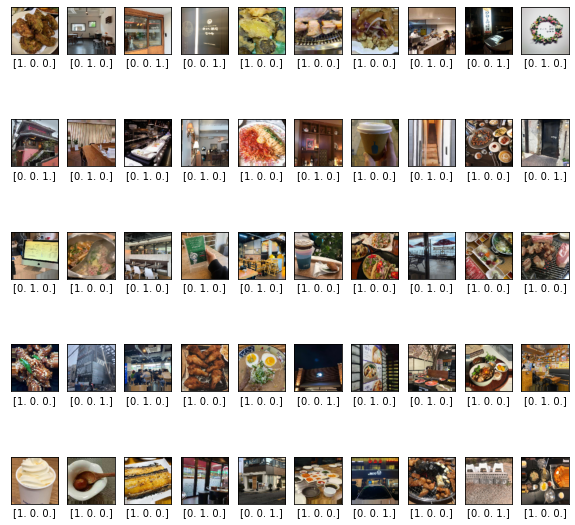

In [ ]:
#테스트 데이터가 잘 저장이 되었는지 확인
plt.figure(figsize=(10,10))
for i in range(50):
  rand = random.randrange(0, len(test_labels))
  plt.subplot(5, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[rand]/255, cmap=plt.cm.binary)
  plt.xlabel(test_labels[rand])
plt.show()

In [ ]:
num_classes = 3
epochs = 10

In [ ]:
#모델1 - Rescaling 미적용
model1 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          GlobalAveragePooling2D(),
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
dropout_16 (Dropout)         (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 300, 300, 64)      36928     
_________________________________________________________________
dropout_17 (Dropout)         (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 150, 150, 128)     73856     
_________________________________________________________________
dropout_18 (Dropout)         (None, 150, 150, 128)   

In [ ]:
#모델2 - Rescaling 미적용 Dropout, BN 적용
model2 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          Dropout(0.3),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2), strides=(2, 2)),

                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(128, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(256, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

                          GlobalAveragePooling2D(),
                          Dense(512, activation=tf.nn.relu),
                          
                          Dense(512, activation=tf.nn.relu),

                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
batch_normalization_16 (Batc (None, 300, 300, 64)      256       
_________________________________________________________________
dense_21 (Dense)             (None, 300, 300, 64)      4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 300, 300, 64)      36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 300, 300, 64)      256       
_________________________________________________________________
dense_22 (Dense)             (None, 300, 300, 64)     

In [ ]:
#모델3 - BN 적용 Dropout은 아래 Dense에 적용
model3 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(128, activation=tf.nn.relu),
                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(128, activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(256, activation=tf.nn.relu),
                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(256, activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),

                          GlobalAveragePooling2D(),
                          Dense(512, activation=tf.nn.relu),
                          Dropout(0.3),
                          Dense(512, activation=tf.nn.relu),
                          Dropout(0.3),
                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 64)      256       
_________________________________________________________________
dense (Dense)                (None, 300, 300, 64)      4160      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 300, 300, 64)      4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0

In [ ]:
#모델4 - BN 적용, 유닛 수 반으로 줄임, Rescaling 적용
model4 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          Rescaling(1/255.),
                          
                          Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(32, activation=tf.nn.relu),
                          Dropout(0.3),
                          Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(32, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Dense(64, activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          GlobalAveragePooling2D(),
                          Dense(128, activation=tf.nn.relu),
                           
                          Dense(128, activation=tf.nn.relu),
                           
                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 300, 300, 32)      128       
_________________________________________________________________
dense_43 (Dense)             (None, 300, 300, 32)      1056      
_________________________________________________________________
dropout_20 (Dropout)         (None, 300, 300, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 300, 300, 32)      9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 300, 300, 32)     

In [ ]:
#모델5 - Dropout만 적용, Rescaling 적용 모델 1과 비교
model5 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          Rescaling(1/255.),
                          
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu),
                          Dropout(0.3),
                          MaxPooling2D(pool_size=(2,2)),

                          GlobalAveragePooling2D(),
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
dropout_24 (Dropout)         (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 300, 300, 64)      36928     
_________________________________________________________________
dropout_25 (Dropout)         (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 150, 150, 128)    

In [ ]:
#모델6 - BN만 적용, Rescaling 적용, 모델5와 비교
model6 = keras.Sequential([
                          Input(shape=(300, 300, 3), name='input_layer'),
                          Rescaling(1/255.),
                          
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Activation(activation=tf.nn.relu),
                          Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Activation(activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),
                          
                          Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Activation(activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),

                          
                          Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                          BatchNormalization(),
                          Activation(activation=tf.nn.relu),
                          MaxPooling2D(pool_size=(2,2)),
                          

                          GlobalAveragePooling2D(),
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(512, activation=tf.nn.relu),
                           
                          Dense(3, activation=tf.nn.softmax, name='output_layer')
])
model6.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_21 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 300, 300, 64)      1792      
_________________________________________________________________
batch_normalization_61 (Batc (None, 300, 300, 64)      256       
_________________________________________________________________
activation_17 (Activation)   (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 300, 300, 64)      36928     
_________________________________________________________________
batch_normalization_62 (Batc (None, 300, 300, 64)      256       
_________________________________________________________________
activation_18 (Activation)   (None, 300, 300, 64)    

In [ ]:
#모델 컴파일
model6.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model6.fit(train_gen, epochs=epochs, validation_data=valid_gen ,callbacks=[early_stopping], verbose=1)

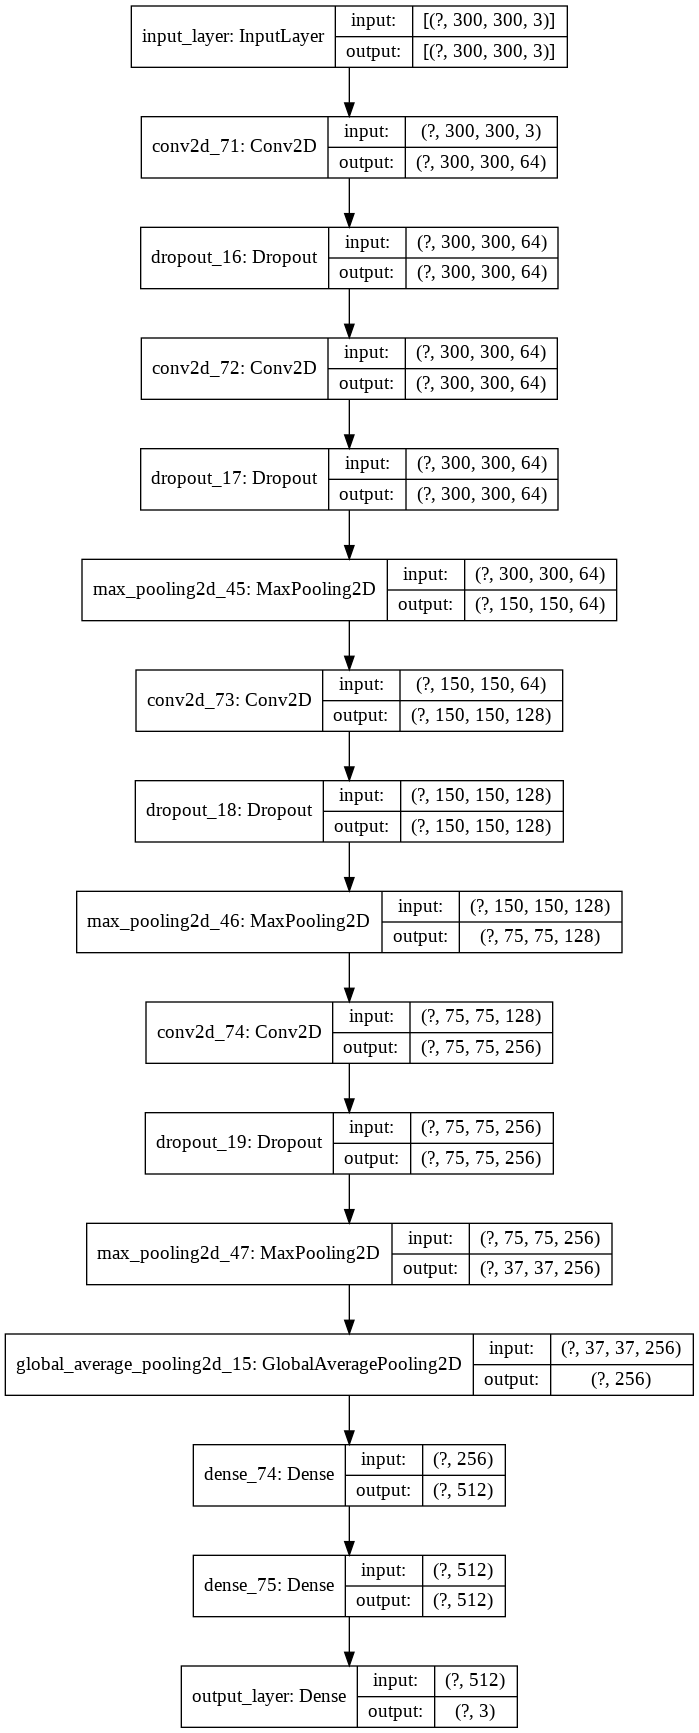

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model7, show_shapes=True, to_file='model_shapes7.png')

In [ ]:
model7.save('model-201611265-7')

INFO:tensorflow:Assets written to: model-201611265-1/assets


In [ ]:
!mv model-201611265-7 /content/gdrive/MyDrive/데사개
!mv model_shapes7.png /content/gdrive/MyDrive/데사개

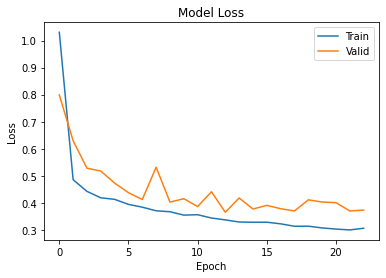

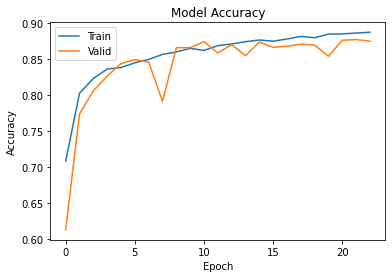

In [ ]:
#Loss, Accuracy 그래프 출력
def plt_show_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Valid'], loc=0)
def plt_show_acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Valid'], loc=0)
plt_show_loss(history)
plt.show()
plt_show_acc(history)
plt.show()

In [ ]:
#테스트 데이터 성능 분석
valid_gen.reset()
loss, acc = model7.evaluate(valid_gen)

print("\nLoss: {}, Acc: {}".format(loss, acc))

282/282 [==============================] - 45s 158ms/step - loss: 0.3734 - accuracy: 0.8749

Loss: 0.3733696937561035, Acc: 0.8748888969421387


In [ ]:
valid_gen.reset()
predictions = model7.predict_generator(valid_gen)

In [ ]:
len(predictions)

9000

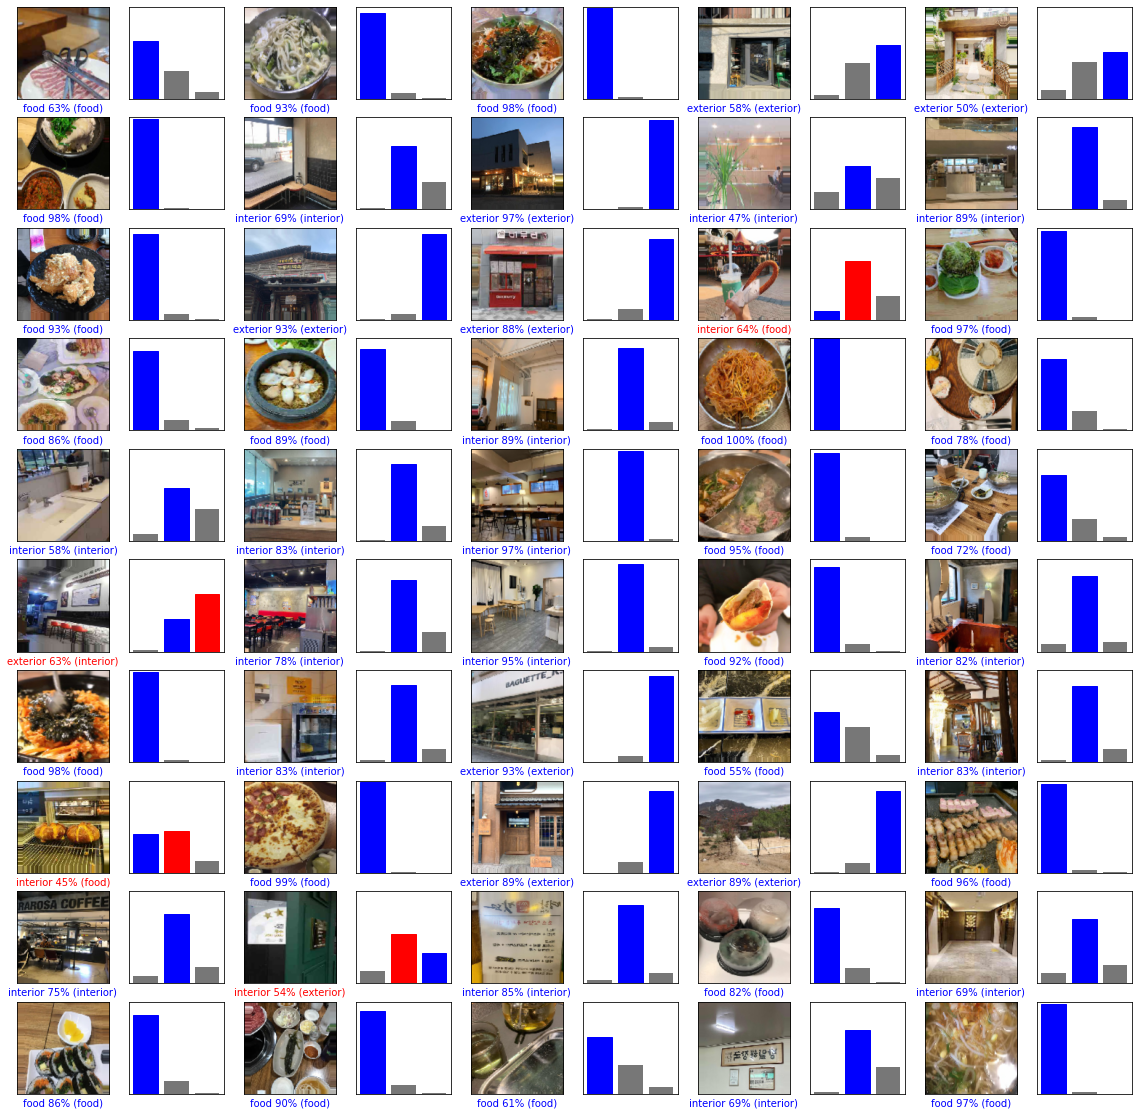

In [ ]:
def plot_img(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img/255, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == np.argmax(true_label):
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[np.argmax(true_label)]),
             color = color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('blue')

num_rows = 10
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  rand = random.randrange(0, len(predictions))
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_img(rand, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(rand, predictions, test_labels)
plt.show()

In [ ]:
def classification_performance_eval(y, y_predict):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y, y_predict)
    precision = precision_score(y, y_predict, average=None, zero_division=0)
    recall = recall_score(y, y_predict, average=None, zero_division=0)
    f1 = f1_score(y, y_predict, average=None, zero_division=0)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1_score = classification_performance_eval(valid_gen.classes, np.argmax(predictions, axis=1))

print("accuracy=%f" %accuracy)
print("precision(Food)=%f" %precision[0])
print("precision(Interior)=%f" %precision[1])
print("precision(Exterior)=%f" %precision[2])
print("recall(Food)=%f" %recall[0])
print("recall(Interior)=%f" %recall[1])
print("recall(Exterior)=%f" %recall[2])
print("f1_score(Food)=%f" %f1_score[0])
print("f1_score(Interior)=%f" %f1_score[1])
print("f1_score(Exterior)=%f" %f1_score[2])

accuracy=0.875667
precision(Food)=0.942843
precision(Interior)=0.787906
precision(Exterior)=0.890673
recall(Food)=0.948500
recall(Interior)=0.881667
recall(Exterior)=0.721000
f1_score(Food)=0.945663
f1_score(Interior)=0.832154
f1_score(Exterior)=0.796905
